In [20]:
# Import torch
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from Utils import *
import string

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import os
import zipfile
from pathlib import Path
import torchvision.transforms as transforms
import requests

In [21]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Setup path to data folder
data_path = Path("/app/dataset")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

/app/Pytorch For DL/Module5/data/pizza_steak_sushi directory exists.


In [23]:
# setup the path for the datasets
train_dir = image_path / "train"
test_dir = image_path / "test"

When using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.
, i.e. mini batches of 3-channel rgb images of shape (3 x H x W) where the height and width has to be at least 224

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].


In [24]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
# Get the transforms used for the pretrained mdoel
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [25]:
# or you could just do it manually like a maniac
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])


In [26]:
train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=auto_transforms,target_transform=None)
test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=auto_transforms,target_transform=None)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

okay, lets get down to the model itself
our models havent been performing that well, because we've been making them from scratch.Now we get to transfer learning, where we take a well performing model on a similar problem-space and then customize it to our use case.  
We have several of it available directly to call on torchvision:
| Model Family      | TorchVision Model Call                                     |
|-------------------|-------------------------------------------------------------|
| ResNet            | `torchvision.models.resnet18()`, `torchvision.models.resnet50()` |
| VGG               | `torchvision.models.vgg16()`                                |
| EfficientNet      | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()` |
| Vision Transformer (ViT) | `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()` |
| ConvNeXt          | `torchvision.models.convnext_tiny()`, `torchvision.models.convnext_small()` |


performance vs. speed vs. size is a big consideration here, since models with bigger params tend to perform better but they're more compute hungry

Anyways, lets just get the model shall we
Usually you would want to freeze and train it on the unfrozen layers only, but in this case we're gonna adapt it and change the output layer

In [27]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [28]:
# lets see what its made of!
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

We can see that its made out of 3 main parts
1. Features - conv and stuff to learn the base representation of data
2. AVGPool - takes the average and turn into feature vector
3. Classifier - Turns the feature vector into a vector with the same dimensionality as the output class(1000 in this case cause of the initial data)

We can view the model summary(with prettier outputs) by using torchinfo.

In [29]:
!pip install torchinfo

In [30]:
# Print a summary using torchinfo (uncomment for actual output)
from torchinfo import summary
summary(model=model, 
        input_size=(32, 3, 224, 224), #
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

After the summary, we can see the input and output of each layer, the total params and of course the trainable layers

Enough Distraction, Lets get straight into how we do this
The process of transfer learning usually goeslike this:
1. Freeze some base layers of a pretrained model (typically the features section) 
2. Adjust the output layers (also called head/classifier layers) or other layers to suit your needs.

In [31]:
# here we freeze all radient updates by calling requires grad = false
# these frozen parameters won't be changed by the optimizer
for param in model.features.parameters():
    param.requires_grad = False
# also, again the right now our pretrained has 1000 classes because there are 1000 classes in imagenet
# we can change the classifier by creating a new series of layers

Note: Dropout layers randomly remove connections between two neural network layers with a probability of p. For example, if p=0.2, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are more general).

In [32]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
class_names=train_data.classes
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, 
                    bias=True)).to(device)

In [33]:
# lets visuzalize it again to see what changed
summary(model, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

See that only the final layer is trainable
now, lets train

In [34]:
# Define loss and optimizer
from Utils import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
from Utils import accuracy_fn
acc_fn = accuracy_fn

In [35]:

from tqdm.auto import tqdm


def train_withdataloader(epochs:int, model:torch.nn.Module, train_dataloader, test_dataloader, loss_fn, accuracy_fn, optimizer, device:string):
    # epochs=15
    train_loss_values=[]
    test_loss_values=[]
    train_acc_values=[]
    test_acc_values=[]
    epoch_count =[]
    for epoch in tqdm(range(epochs)):
        print(f"epoch: {epoch}")
        model.to(device)
        model.train()
        train_loss, train_acc = 0, 0
        test_loss, test_acc = 0, 0
        for batch, (X,y) in enumerate(train_dataloader):
            X,y=X.to(device),y.to(device)
            logits=model(X)
            loss=loss_fn(logits,y)
            train_loss+=loss
            
            train_acc+=accuracy_fn(y, logits.argmax(dim=1))
            # zero grad
            optimizer.zero_grad()
            # loss backward
            loss.backward()
            # backprop
            optimizer.step()
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        model.to(device)
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        model.eval()
        with torch.inference_mode():
            for X,y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_logits=model(X)
                test_loss+=loss_fn(test_logits,y)
                test_acc+=accuracy_fn(y, test_logits.argmax(dim=1))
            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)
        train_loss_values.append(train_loss.detach().numpy())
        train_acc_values.append(train_acc)
        test_loss_values.append(test_loss.detach().numpy())
        test_acc_values.append(test_acc)
        epoch_count.append(epoch)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
    return {"train_loss": train_loss_values,
             "train_acc": train_acc_values,
             "test_loss": test_loss_values,
             "test_acc": test_acc_values}


In [36]:
result=train_withdataloader(2, model, train_dataloader, test_dataloader,loss_fn, acc_fn, optimizer, device)

  0%|          | 0/2 [00:00<?, ?it/s]

epoch: 0
Train loss: 1.16863 | Train accuracy: 31.11%


 50%|█████     | 1/2 [00:12<00:12, 12.04s/it]

Test loss: 1.08717 | Test accuracy: 37.33%
epoch: 1
Train loss: 1.10938 | Train accuracy: 39.56%


100%|██████████| 2/2 [00:24<00:00, 12.48s/it]

Test loss: 1.06383 | Test accuracy: 48.00%


In [37]:
result

{'train_loss': [array(1.1686314, dtype=float32),
  array(1.1093806, dtype=float32)],
 'train_acc': [31.11111111111111, 39.55555555555556],
 'test_loss': [array(1.0871676, dtype=float32),
  array(1.0638264, dtype=float32)],
 'test_acc': [37.333333333333336, 48.0]}

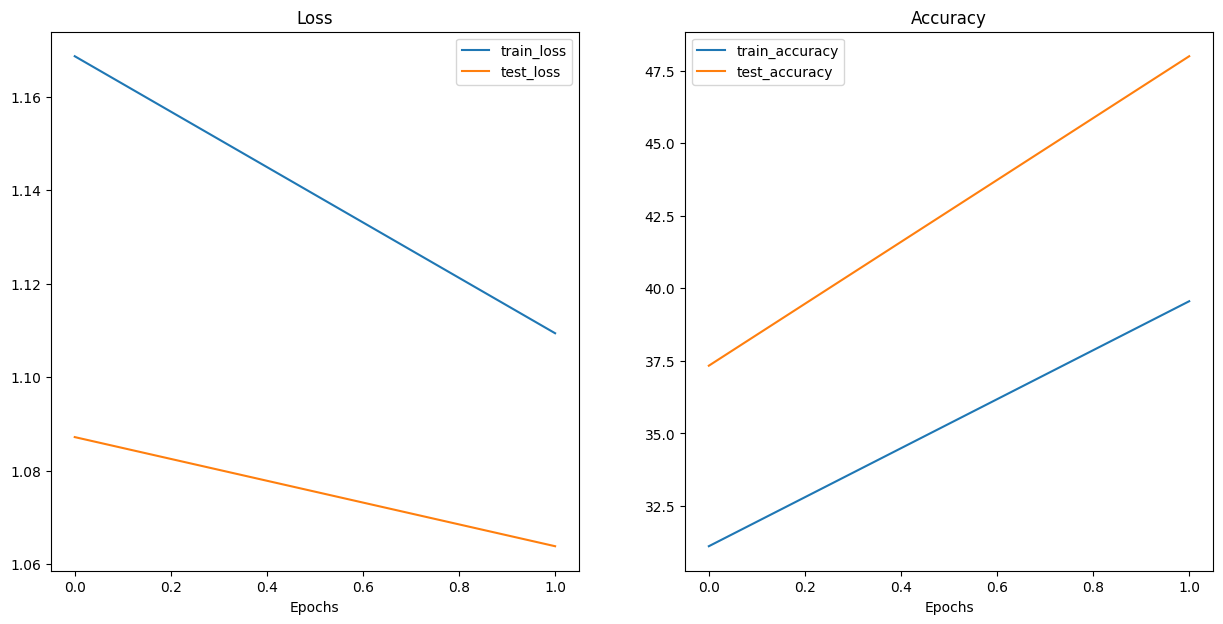

In [38]:
from Utils import plot_loss_curves
plot_loss_curves(result)

In [54]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    if isinstance(image_path, str) or isinstance(image_path, Path):
        img = Image.open(image_path).convert("RGB")
    else:
        img = image_path  # Already a PIL Image

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

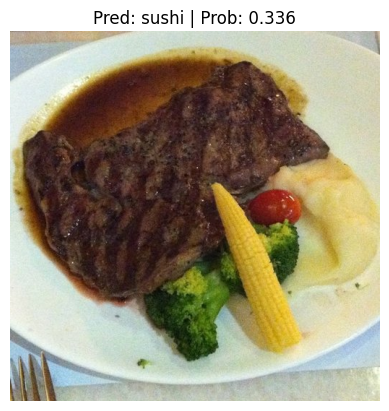

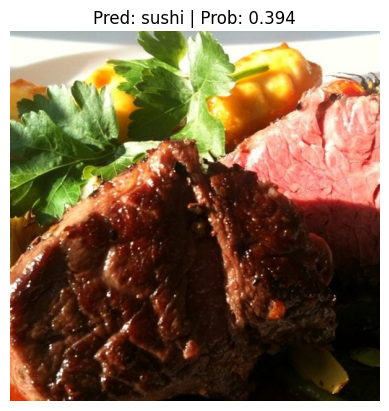

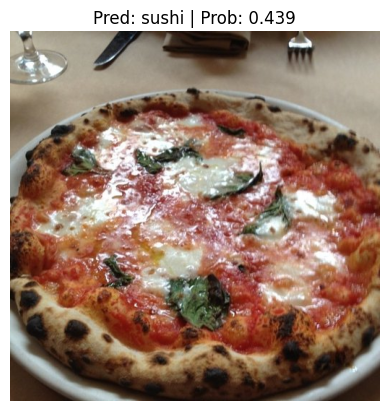

In [55]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        # image_size=(224, 224)
                        )

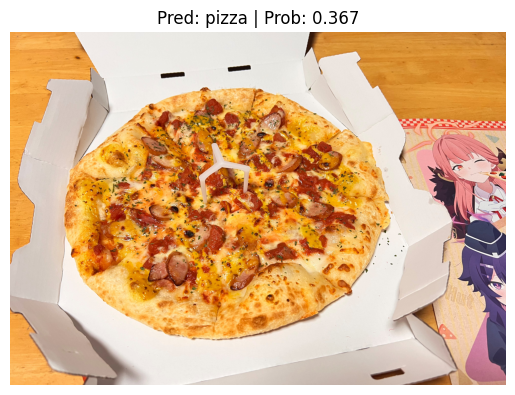

In [56]:
custom_image_path = data_path / "arupizza.png"
from PIL import Image

image = Image.open(custom_image_path).convert("RGB")

pred_and_plot_image(model=model,
                    image_path=image,  # ← This is now a PIL Image, not a path
                    class_names=class_names)

